# Abstract

Este proyecto tiene como objetivo analizar un conjunto de datos que contiene información sobre los viajes realizados mediante el servicio de renta de bicicletas de una empresa local (divvybikes) en el año 2020, en la ciudad de Chicago. La meta es evaluar el flujo de usuarios y los patrones de movilidad, promoviendo el uso de la bicicleta como una alternativa sustentable para reducir las emisiones de CO₂ provenientes de los automóviles. El análisis se lleva a cabo en Visual studio code utilizando Python, lo que permite un procesamiento interactivo y visualización de datos a través de diversas librerías como Pandas, Matplotlib y Seaborn.


# Introduccion

El creciente interés en soluciones de movilidad sostenible ha impulsado a diversas ciudades a fomentar el uso de la bicicleta. En este contexto, el análisis de datos provenientes de empresas de renta de bicicletas se vuelve esencial para comprender la dinámica de uso, identificar horas pico, rutas preferentes y otros factores que impactan en la planificación urbana. Este proyecto se propone explorar el dataset, identificar tendencias y generar insights que puedan ser utilizados por gestores urbanos y empresas privadas para optimizar sus servicios.


# Objetivos

1. Analizar el flujo de viajes: Identificar patrones diarios y semanales en el uso del servicio.
2. Estudiar la eficiencia del servicio: Determinar las rutas más demandadas y el tiempo promedio de viaje.
3. Fomentar la movilidad sustentable: Utilizar los resultados para promover el uso de la bicicleta en áreas urbanas, contribuyendo a la disminución de emisiones contaminantes.

4. Optimizar recursos: Brindar recomendaciones para la asignación de bicicletas y estaciones en función de la demanda real.


# Descripcion del dataset

El dataframe a analizar contiene las siguientes columnas:

- ride_id: Identificador único de cada viaje.
- rideable_type: Tipo de bicicleta utilizada (por ejemplo, estándar, eléctrica, etc.).
- started_at: Fecha y hora en que inicia el viaje.
- ended_at: Fecha y hora en que finaliza el viaje.
- start_station_name: Nombre de la estación de donde inicia el viaje.
- end_station_name: Nombre de la estación donde finaliza el viaje.
- start_lat: Latitud de la ubicación de inicio.
- start_lng: Longitud de la ubicación de inicio.
- end_lat: Latitud de la ubicación de finalización.
- end_lng: Longitud de la ubicación de finalización.
- member_casual: Tipo de usuario, indicando si el viaje fue realizado por un miembro o un usuario casual.


In [53]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import folium
from IPython.display import display

In [4]:
df = pd.read_csv("data/data_frame.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426887 entries, 0 to 426886
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             426887 non-null  object 
 1   rideable_type       426887 non-null  object 
 2   started_at          426887 non-null  object 
 3   ended_at            426887 non-null  object 
 4   start_station_name  426887 non-null  object 
 5   start_station_id    426887 non-null  int64  
 6   end_station_name    426886 non-null  object 
 7   end_station_id      426886 non-null  float64
 8   start_lat           426887 non-null  float64
 9   start_lng           426887 non-null  float64
 10  end_lat             426886 non-null  float64
 11  end_lng             426886 non-null  float64
 12  member_casual       426887 non-null  object 
dtypes: float64(5), int64(1), object(7)
memory usage: 42.3+ MB


In [5]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id        int64
end_station_name       object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

# Identificando valores nulos


In [6]:
df.isnull().sum().sum()


4

Identificamos que tenemos 4 valores nulos


<Axes: >

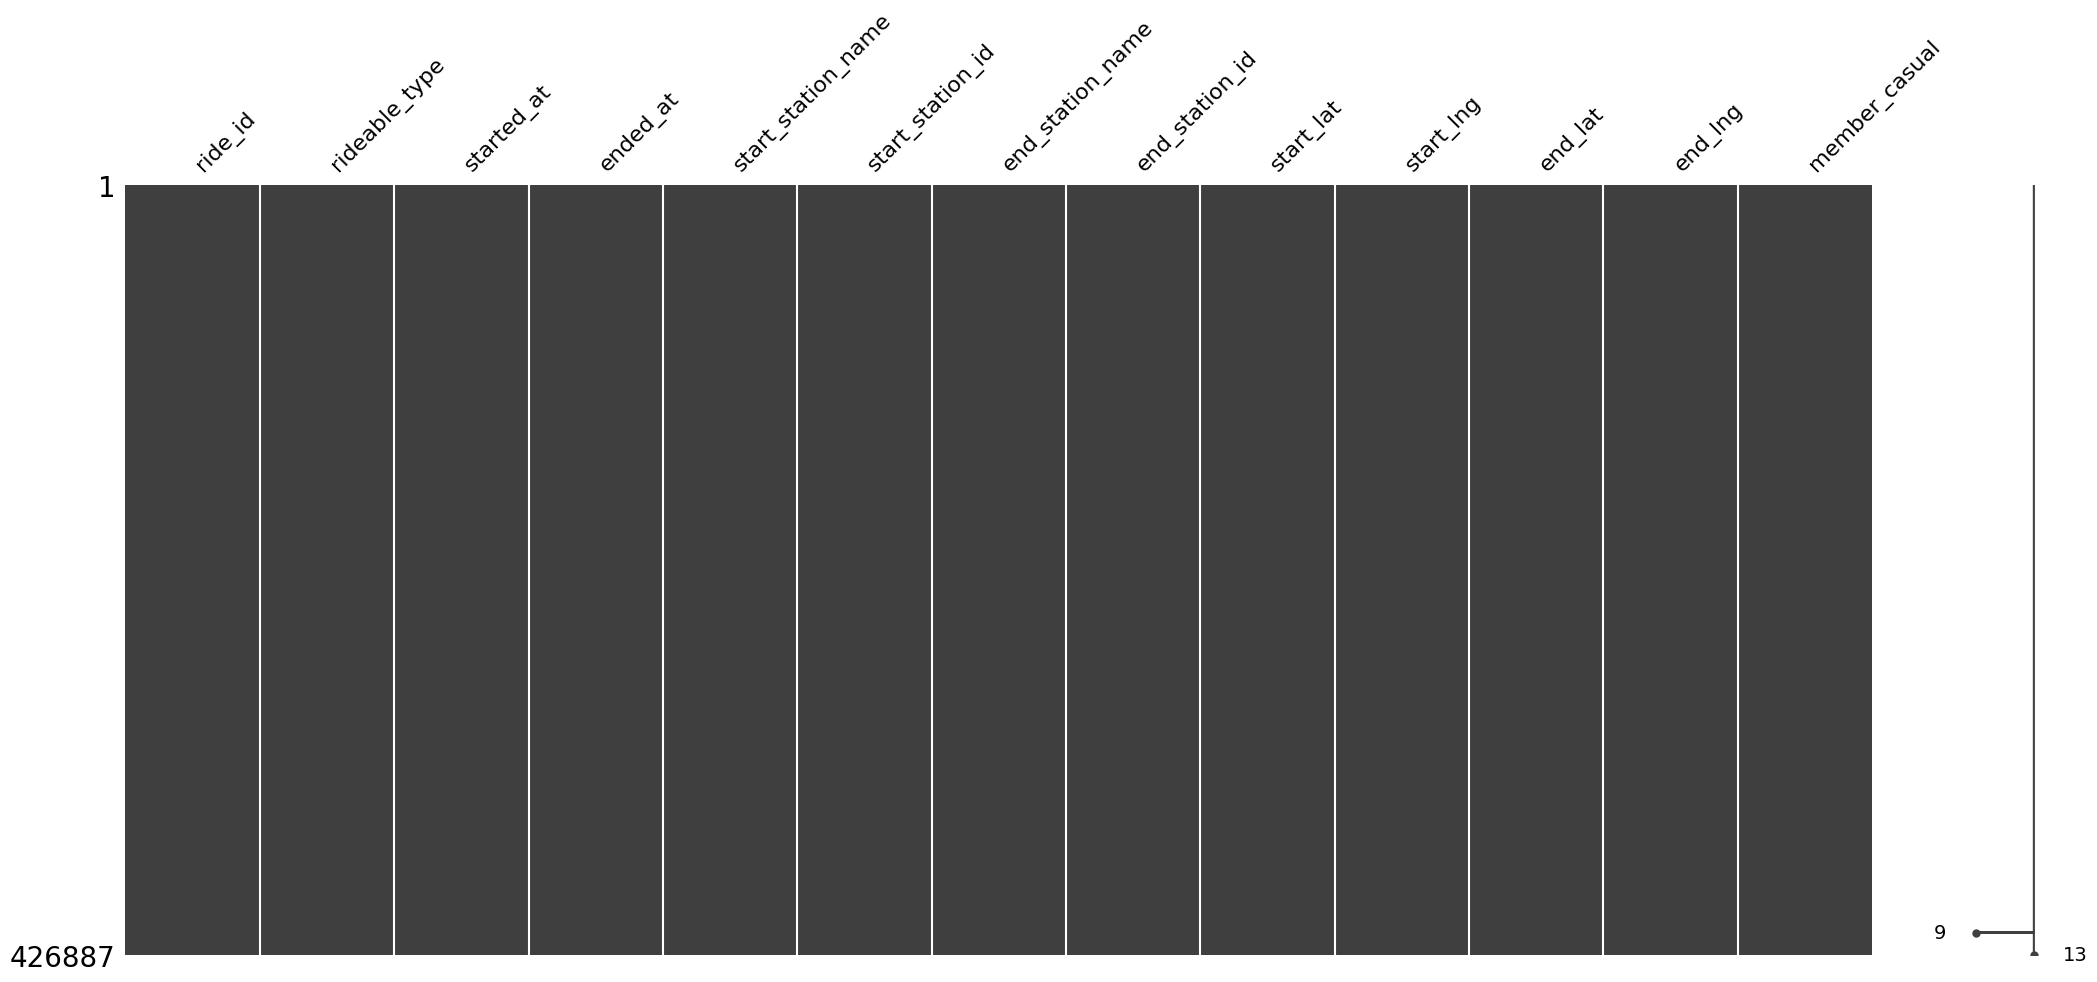

In [7]:
msno.matrix(df)


<Axes: >

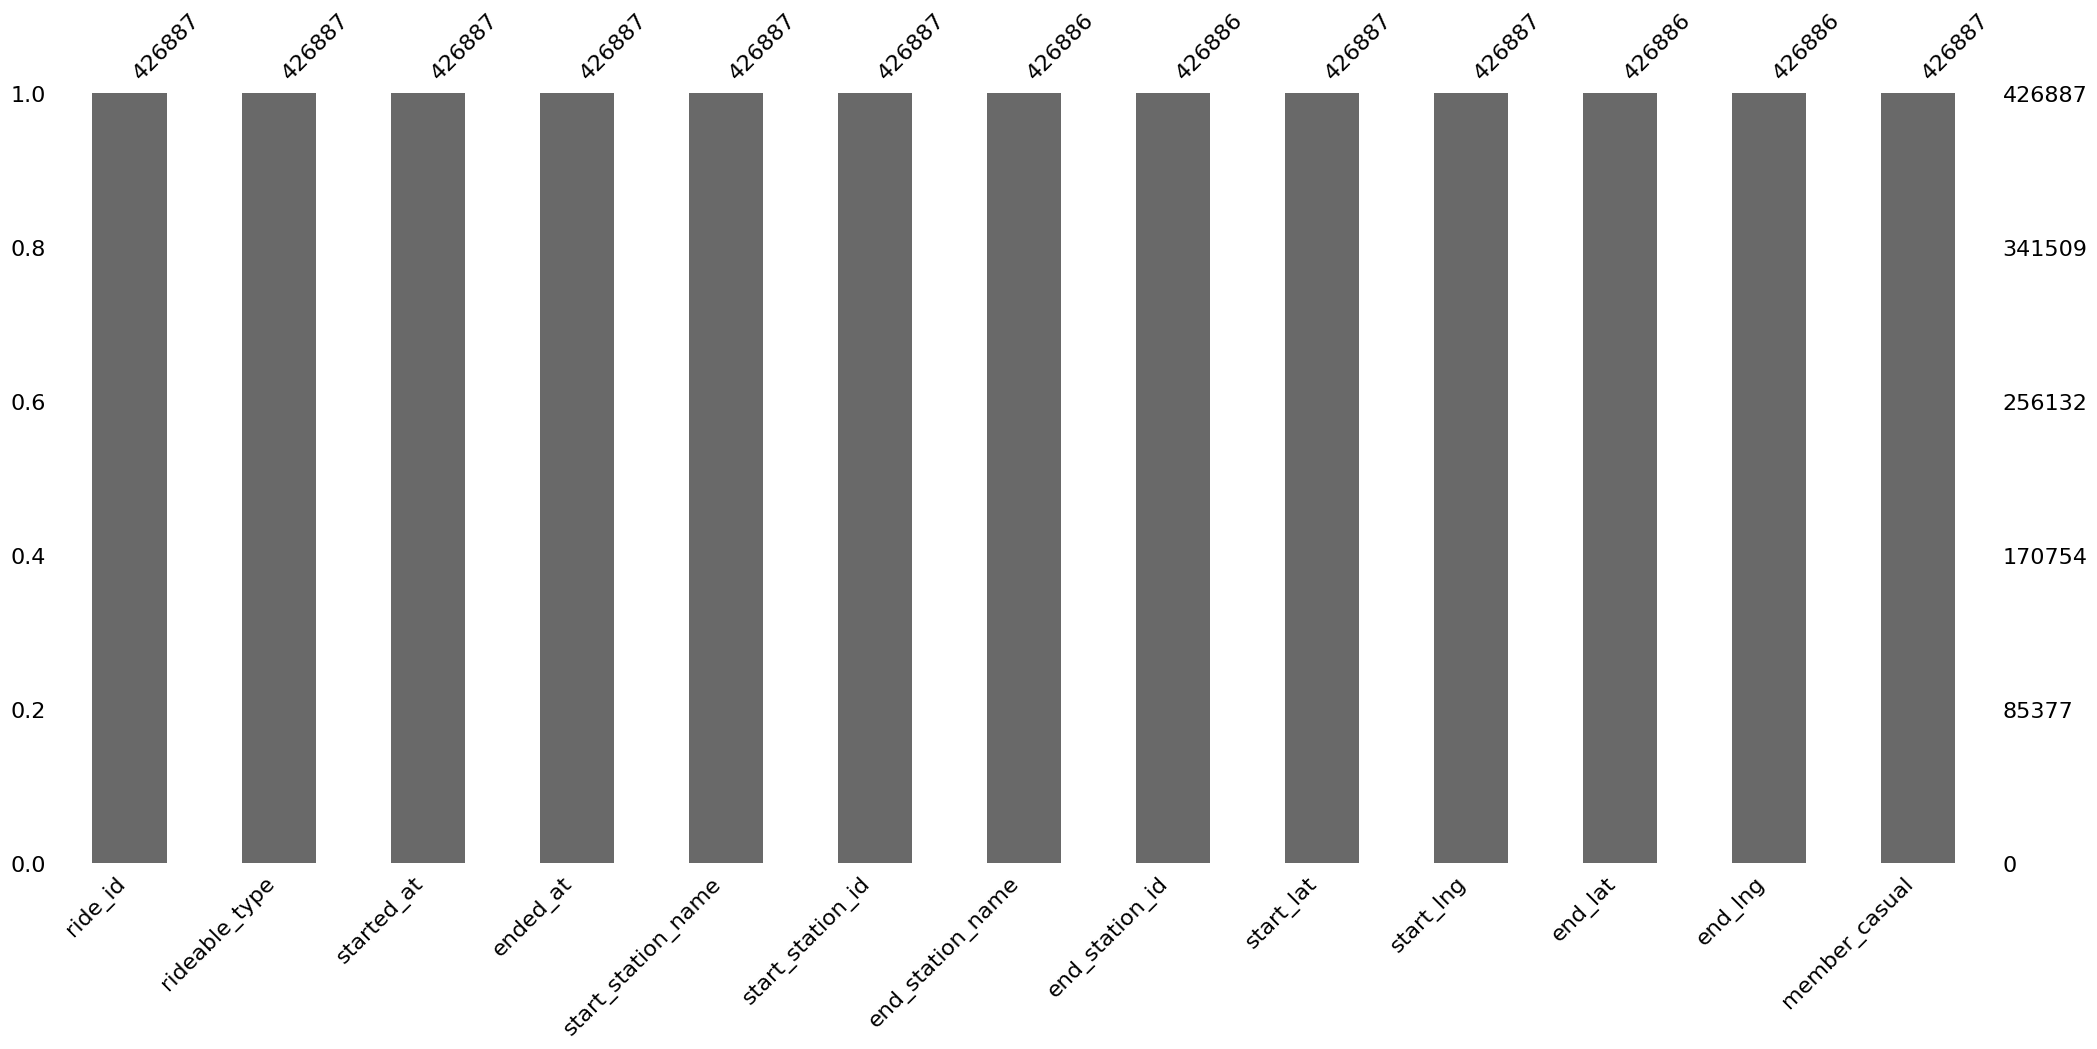

In [8]:
msno.bar(df)

Con esta funcion podemos ver en dodne tenemos nuestros valores nulos


# Resolviendo nulos


In [9]:
col = "end_station_name"
col2 = "end_station_id"
col3 = "end_lat"
col4 = "end_Ing"

filas_con_nulos = df[df.isna().any(axis=1)]
display(filas_con_nulos)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
414426,157EAA4C4A3C8D36,docked_bike,16/03/2020 11:23,16/03/2020 11:23,HQ QR,675,NaN,NaN,41.8899,-87.6803,NaN,NaN,casual


Se puede observar que los 4 datos nulos esta en 1 registro. Por lo que se procede a hacer la limpieza de los datos.


# Limpieza de datos


En este caso como pudimos observar solo 2 registros tenian 2 valores nulos cada uno por lo que podemos eliminar los valores para no tener errores en el analisis.


<Axes: >

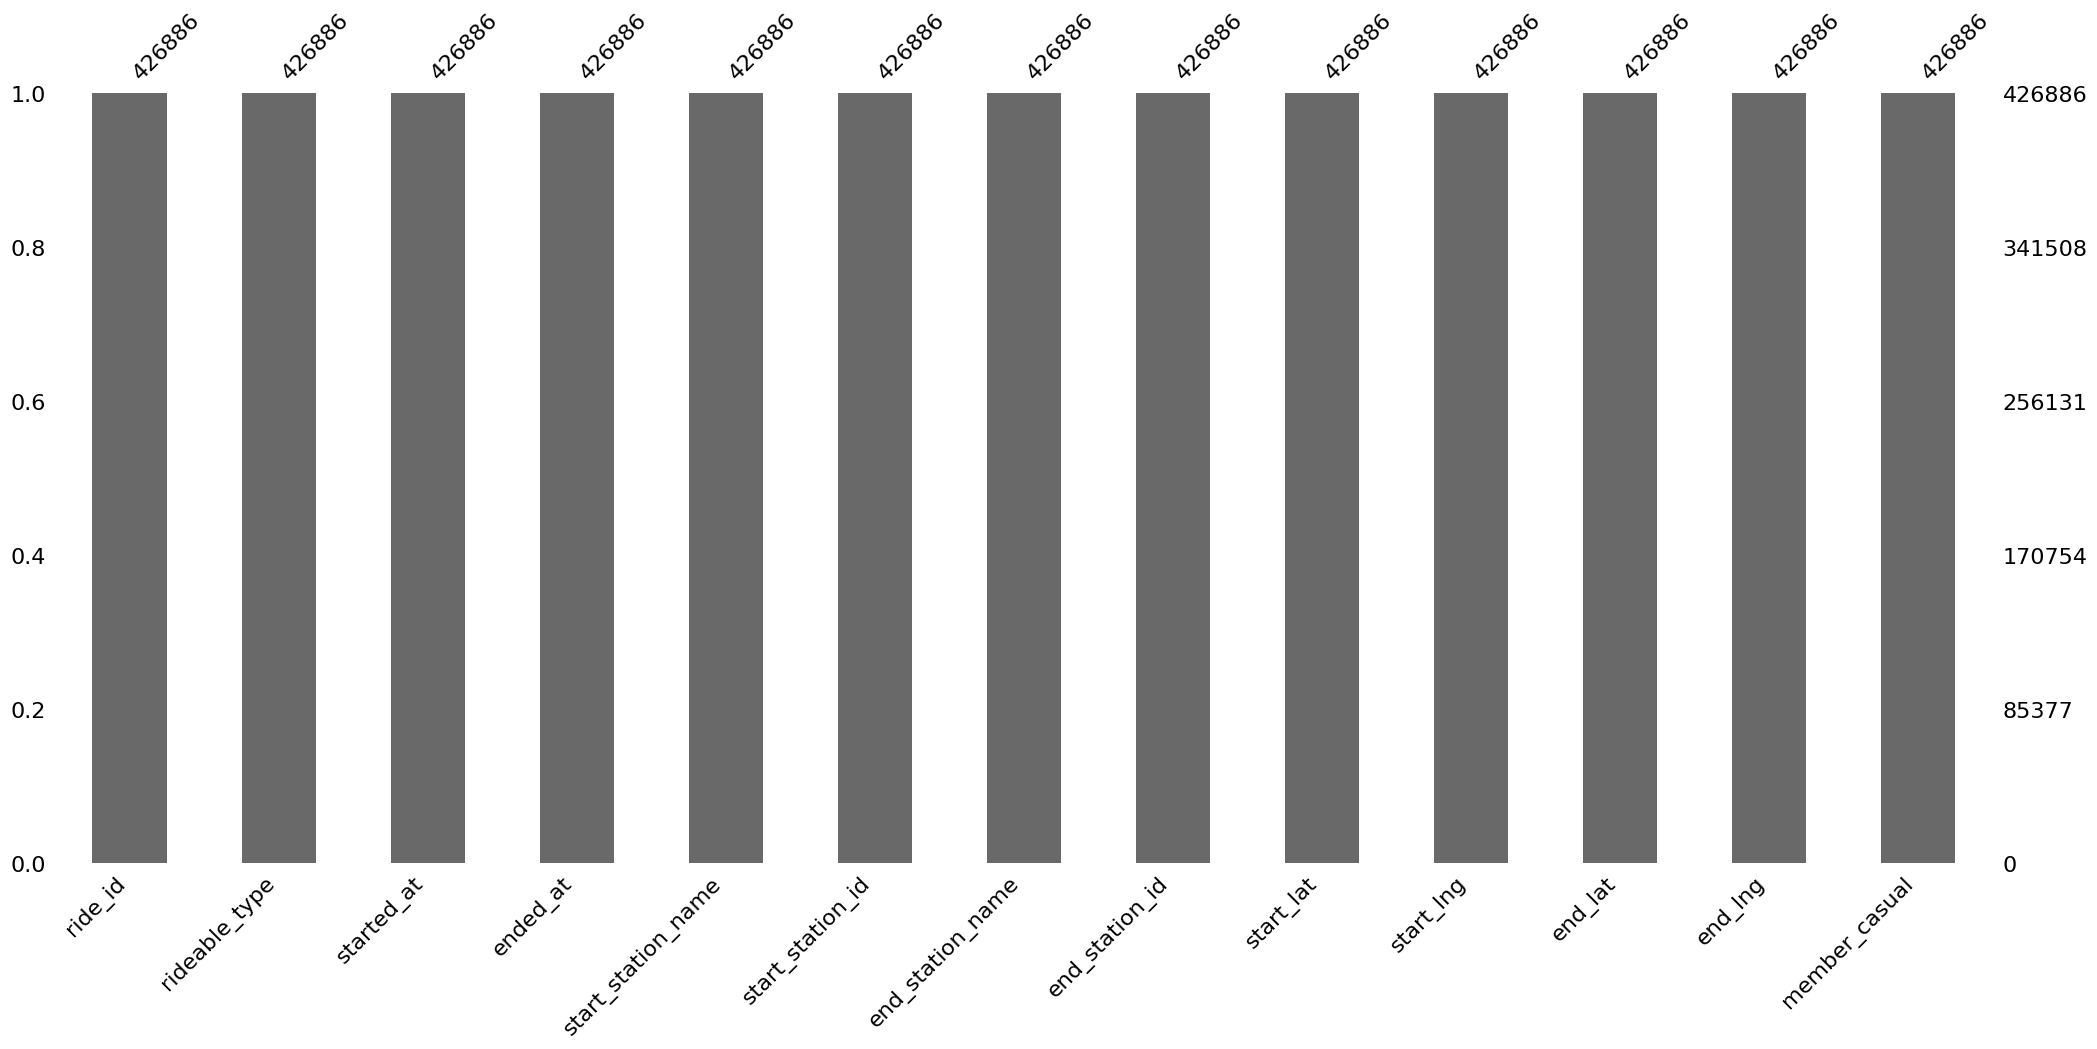

In [10]:
#df_clean = df.copy()

df_clean = df.copy().dropna()
msno.bar(df_clean)

In [11]:
df_clean.isnull().sum().sum()

0

Se observa que ya no existen esos valores nulos que observamos en la matriz pasada


Verificamos que no existan valores duplicados


In [12]:
df_clean.duplicated().sum()

0

# Transformacion de datos y visualizaciones


In [13]:
df_clean['started_at'] = pd.to_datetime(df_clean['started_at'], format= "%d/%m/%Y %H:%M")
df_clean['hour'] = df_clean['started_at'].dt.hour

bins = [0, 8, 10, 12, 14, 16, 18, 20, 22, 24]
labels = ['0-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-24']
df_clean['hours_range'] = pd.cut(df_clean['hour'], bins= bins, labels=labels, right=False)

flow_by_hour_start = df_clean.groupby(['hours_range', 'start_station_name']).size().reset_index(name='travels')
display(flow_by_hour_start)

C:\Users\alvar\AppData\Local\Temp\ipykernel_5460\3131317910.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flow_by_hour_start = df_clean.groupby(['hours_range', 'start_station_name']).size().reset_index(name='travels')


,hours_range,start_station_name,travels
0,0-8,2112 W Peterson Ave,2
1,0-8,63rd St Beach,1
2,0-8,900 W Harrison St,80
3,0-8,Aberdeen St & Jackson Blvd,176
4,0-8,Aberdeen St & Monroe St,461
...,...,...,...
5458,22-24,Wood St & Taylor St,16
5459,22-24,Woodlawn Ave & 55th St,36
5460,22-24,Woodlawn Ave & 75th St,0
5461,22-24,Woodlawn Ave & Lake Park Ave,1


In [14]:
flow_by_hour_end = df_clean.groupby(['hours_range', 'end_station_name']).size().reset_index(name='travels')
display(flow_by_hour_end)

C:\Users\alvar\AppData\Local\Temp\ipykernel_5460\2872918184.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flow_by_hour_end = df_clean.groupby(['hours_range', 'end_station_name']).size().reset_index(name='travels')


,hours_range,end_station_name,travels
0,0-8,2112 W Peterson Ave,10
1,0-8,63rd St Beach,4
2,0-8,900 W Harrison St,127
3,0-8,Aberdeen St & Jackson Blvd,133
4,0-8,Aberdeen St & Monroe St,87
...,...,...,...
5413,22-24,Wood St & Taylor St,2
5414,22-24,Woodlawn Ave & 55th St,35
5415,22-24,Woodlawn Ave & 75th St,0
5416,22-24,Woodlawn Ave & Lake Park Ave,6


In [15]:
flow_sorted_start = flow_by_hour_start.sort_values(by=['travels'], ascending=[False])
print(flow_sorted_start)

     hours_range            start_station_name  travels
79           0-8           Canal St & Adams St     2368
750         8-10       Clinton St & Madison St     2091
3270       16-18       Franklin St & Monroe St     2017
147          0-8  Clinton St & Washington Blvd     1927
686         8-10           Canal St & Adams St     1916
...          ...                           ...      ...
2311       12-14         Shields Ave & 43rd St        0
4915       22-24      California Ave & 26th St        0
2263       12-14          Racine Ave & 61st St        0
2248       12-14        Phillips Ave & 79th St        0
5462       22-24          Yates Blvd & 75th St        0

[5463 rows x 3 columns]


Primeras 10 estaciones con el mayor numero de viajes iniciados por un rango de horas durante el año 2020


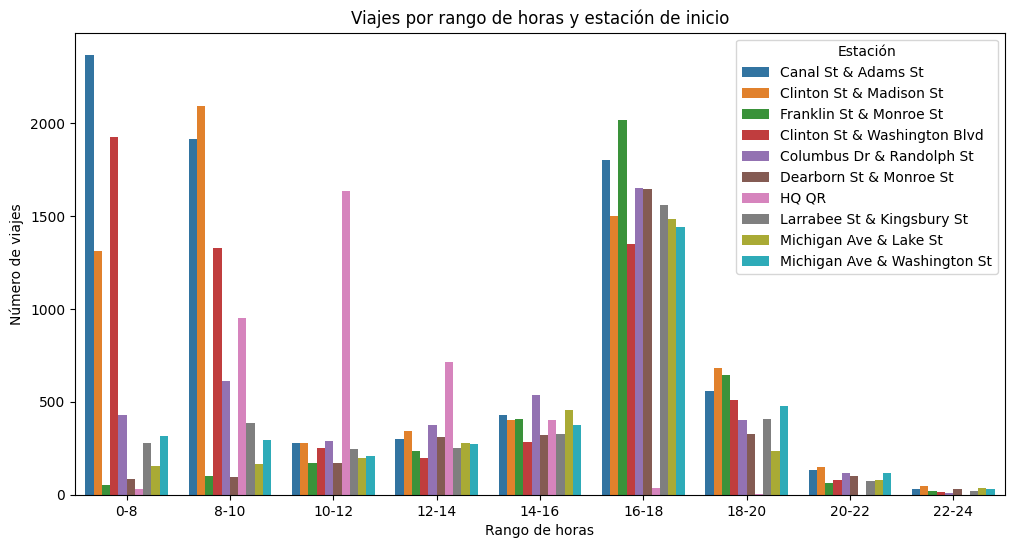

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

firlter_stations = flow_sorted_start['start_station_name'].unique()[:10]
df_filter = flow_sorted_start[flow_sorted_start['start_station_name'].isin(firlter_stations)]

# Gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
sns.barplot(data=df_filter, x='hours_range', y='travels', hue='start_station_name')
plt.title('Viajes por rango de horas y estación de inicio')
plt.xlabel('Rango de horas')
plt.ylabel('Número de viajes')
plt.legend(title='Estación')
plt.show()





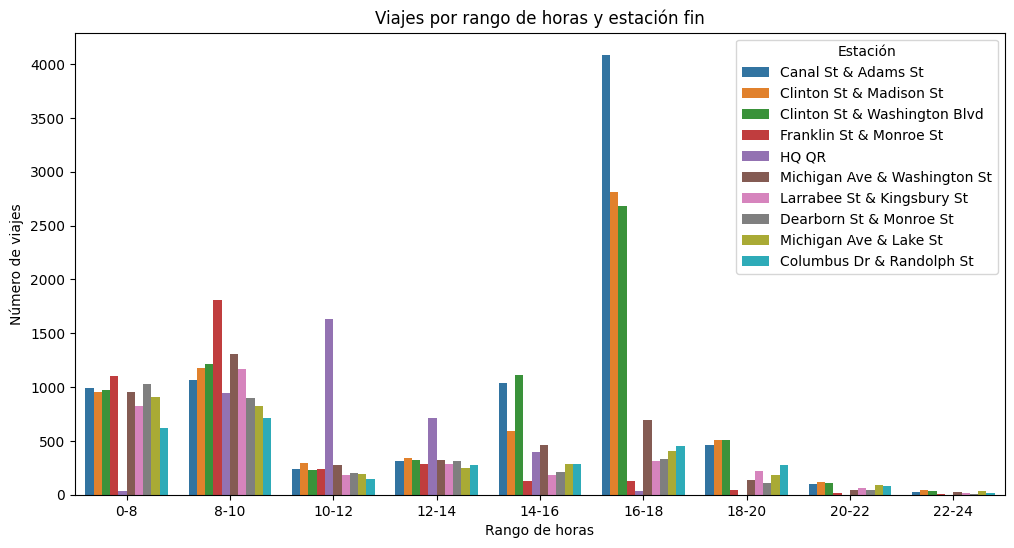

In [18]:
flow_sorted_end = flow_by_hour_end.sort_values(by=['travels'], ascending=[False])

firlter_stations_end = flow_sorted_end['end_station_name'].unique()[:10]
df_filter = flow_sorted_end[flow_sorted_end['end_station_name'].isin(firlter_stations)]

# Gráfico de barras agrupadas
plt.figure(figsize=(12, 6))
sns.barplot(data=df_filter, x='hours_range', y='travels', hue='end_station_name')
plt.title('Viajes por rango de horas y estación fin')
plt.xlabel('Rango de horas')
plt.ylabel('Número de viajes')
plt.legend(title='Estación')
plt.show()

In [19]:
display(df_clean)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,hour,hours_range
0,EACB19130B0CDA4A,docked_bike,2020-01-21 20:06:00,21/01/2020 20:14,Western Ave & Leland Ave,239,Clark St & Leland Ave,326.0,41.9665,-87.6884,41.9671,-87.6674,member,20,20-22
1,8FED874C809DC021,docked_bike,2020-01-30 14:22:00,30/01/2020 14:26,Clark St & Montrose Ave,234,Southport Ave & Irving Park Rd,318.0,41.9616,-87.6660,41.9542,-87.6644,member,14,14-16
2,789F3C21E472CA96,docked_bike,2020-01-09 19:29:00,09/01/2020 19:32,Broadway & Belmont Ave,296,Wilton Ave & Belmont Ave,117.0,41.9401,-87.6455,41.9402,-87.6530,member,19,18-20
3,C9A388DAC6ABF313,docked_bike,2020-01-06 16:17:00,06/01/2020 16:25,Clark St & Randolph St,51,Fairbanks Ct & Grand Ave,24.0,41.8846,-87.6319,41.8918,-87.6206,member,16,16-18
4,943BC3CBECCFD662,docked_bike,2020-01-30 08:37:00,30/01/2020 08:42,Clinton St & Lake St,66,Wells St & Hubbard St,212.0,41.8856,-87.6418,41.8899,-87.6343,member,8,8-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426882,ADDAA33CEBCAE733,docked_bike,2020-03-10 10:40:00,10/03/2020 10:40,HQ QR,675,HQ QR,675.0,41.8899,-87.6803,41.8899,-87.6803,casual,10,10-12
426883,82B10FA3994BC66A,docked_bike,2020-03-07 15:25:00,07/03/2020 16:14,Rush St & Superior St,161,Sheridan Rd & Irving Park Rd,240.0,41.8958,-87.6259,41.9542,-87.6544,member,15,14-16
426884,AA0D5AAA0B59C8AA,docked_bike,2020-03-01 13:12:00,01/03/2020 13:38,Clark St & Lincoln Ave,141,Ashland Ave & Division St,210.0,41.9157,-87.6346,41.9035,-87.6677,casual,13,12-14
426885,3296360A7BC20FB8,docked_bike,2020-03-07 18:02:00,07/03/2020 18:13,Franklin St & Illinois St,672,Stetson Ave & South Water St,264.0,41.8910,-87.6355,41.8868,-87.6223,member,18,18-20


Podemos observar las 4 principales estaciones donde se inician los viajes y en que horario se tienen mas viajes


In [ ]:
max_travels_end = flow_sorted_end.head(4)
max_travles_start = flow_sorted_start.head(4)
print(max_travles_start)

     hours_range            start_station_name  travels
79           0-8           Canal St & Adams St     2368
750         8-10       Clinton St & Madison St     2091
3270       16-18       Franklin St & Monroe St     2017
147          0-8  Clinton St & Washington Blvd     1927


Podemos observar las 4 principales estaciones donde se terminan los viajes y en que horario se tienen mas viajes


In [52]:
max_travels_end = flow_sorted_end.head(4)
print(max_travels_end)

     hours_range              end_station_name  travels
3089       16-18           Canal St & Adams St     4087
3152       16-18       Clinton St & Madison St     2812
3156       16-18  Clinton St & Washington Blvd     2683
834         8-10       Franklin St & Monroe St     1807


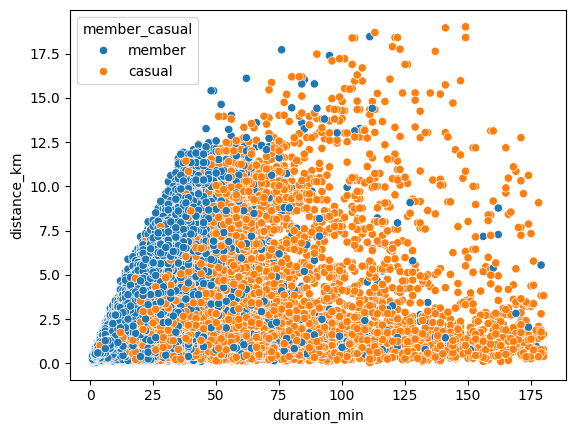

In [58]:
df_clean['started_at'] = pd.to_datetime(df_clean['started_at'])
df_clean['ended_at'] = pd.to_datetime(df_clean['ended_at'])
df_clean['duration_min'] = (df_clean['ended_at'] - df_clean['started_at']).dt.total_seconds() / 60

# Duración máxima razonable: 3 horas (180 minutos)
df_filtered = df_clean[(df_clean['duration_min'] > 0) & (df_clean['duration_min'] <= 180)]
# Distancia máxima razonable: 20 km
df_filtered = df_filtered[(df_filtered['distance_km'] > 0) & (df_filtered['distance_km'] <= 20)]

sns.scatterplot(data=df_filtered, x='duration_min', y='distance_km', hue='member_casual')
plt.show()

Como resultado tenemos que los usuarios casuales tienden a realizar viajes mas largos


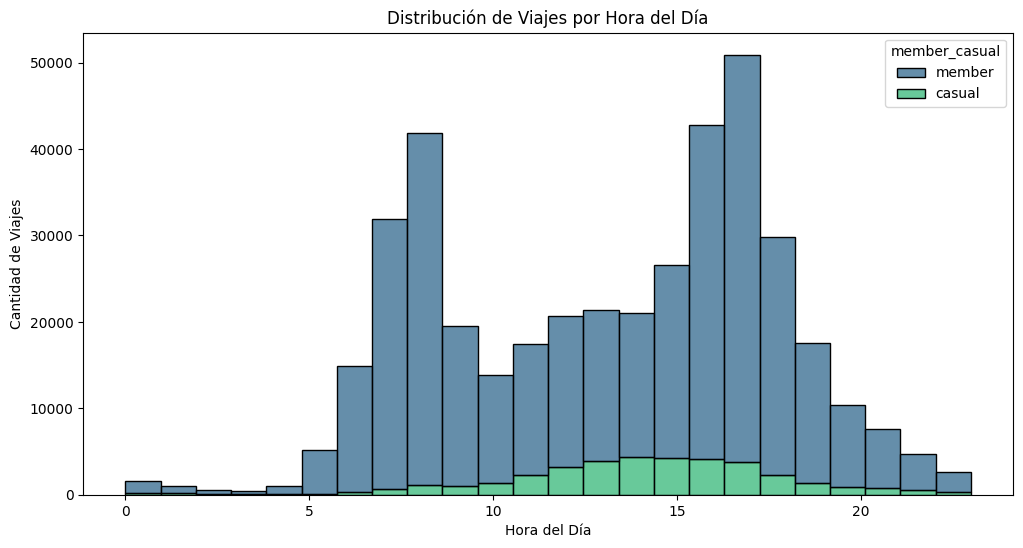

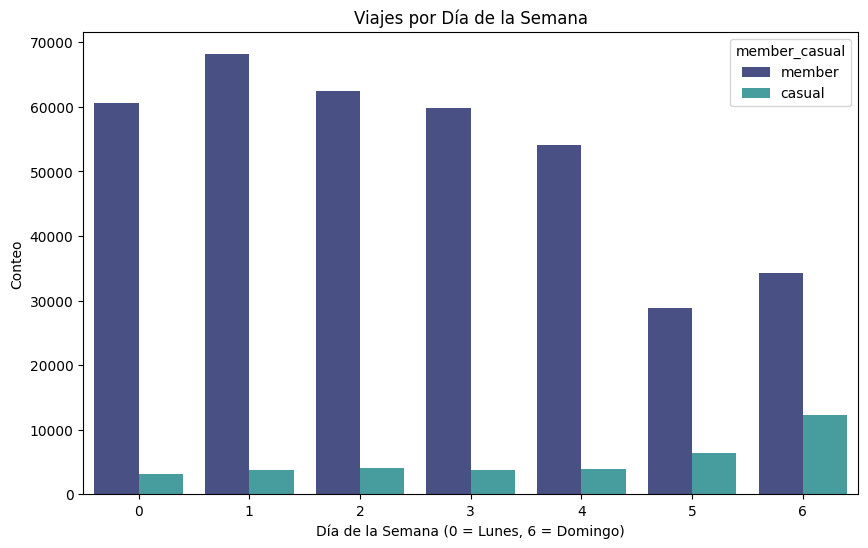

In [59]:
# 1. Hora del día
df_filtered['hour'] = df_filtered['started_at'].dt.hour

# 2. Día de la semana (0 = Lunes, 6 = Domingo)
df_filtered['weekday'] = df_filtered['started_at'].dt.weekday

# 3. Tipo de ruta (1 si inicia y termina en la misma estación)
df_filtered['same_station'] = (df_filtered['start_station_id'] == df_filtered['end_station_id']).astype(int)

# 4. Velocidad promedio (km/h)
df_filtered['speed_kmh'] = df_filtered['distance_km'] / (df_filtered['duration_min'] / 60)

# 5. Mes del año
df_filtered['month'] = df_filtered['started_at'].dt.month

# Distribución de viajes por hora y tipo de usuario
plt.figure(figsize=(12, 6))
sns.histplot(data=df_filtered, x='hour', hue='member_casual', bins=24, multiple='stack', palette='viridis')
plt.title('Distribución de Viajes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Viajes')
plt.show()

# Uso por día de la semana
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='weekday', hue='member_casual', palette='mako')
plt.title('Viajes por Día de la Semana')
plt.xlabel('Día de la Semana (0 = Lunes, 6 = Domingo)')
plt.ylabel('Conteo')
plt.show()

Esto nos muestra el flujo que tenemos por cada de cada tipo de usuario


# Transformaciones y visualizaciones geograficas


In [ ]:

names_stations_start = max_travles_start["start_station_name"].to_list()
names_stations_end = max_travels_end["end_station_name"].to_list()

first_10 = df_clean[df_clean['start_station_name'].isin(names_stations_start)]
first_4 = df_clean[df_clean['end_station_name'].isin(names_stations_end)]

unique_stations = first_10.drop_duplicates(subset=['start_station_name'])
unique_location_end = first_4.drop_duplicates(subset=['end_station_name'])

coordinates = unique_stations[['start_station_name', 'start_lat', 'start_lng']]
coordinates_end = unique_location_end[["end_station_name", 'end_lat', 'end_lng']]

center_lat = (coordinates['start_lat'].mean() + coordinates_end['end_lat'].mean()) / 2
center_lon = (coordinates['start_lng'].mean() + coordinates_end['end_lng'].mean()) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for idx, row in coordinates.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'],
        icon=folium.Icon(color='green')
    ).add_to(m)

m 

Ubicamos en el mapa las 4 estaciones mas concurridas, tanto los inicios de recorrido, como de final de recorrido


In [26]:

top_10_routes = (
    df_clean.groupby(['start_station_name', 'end_station_name', 
                     'start_lat', 'start_lng', 'end_lat', 'end_lng'])
    .size()  
    .nlargest(10) 
    .reset_index(name='count')
)

center_lat = (top_10_routes['start_lat'].mean() + top_10_routes['end_lat'].mean()) / 2
center_lon = (top_10_routes['start_lng'].mean() + top_10_routes['end_lng'].mean()) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

for idx, row in top_10_routes.iterrows():

    start_coords = [row['start_lat'], row['start_lng']]
    end_coords = [row['end_lat'], row['end_lng']]
   
    folium.PolyLine(
        locations=[start_coords, end_coords],
        color='blue',
        weight=3,
        opacity=0.7,
        tooltip=f"Ruta {idx+1}: {row['start_station_name']} → {row['end_station_name']} (Viajes: {row['count']})"
    ).add_to(m)
    
    folium.Marker(
        location=start_coords,
        popup=f"Inicio: {row['start_station_name']}",
        icon=folium.Icon(color='green')
    ).add_to(m)
    
    folium.Marker(
        location=end_coords,
        popup=f"Fin: {row['end_station_name']}",
        icon=folium.Icon(color='red')
    ).add_to(m)

m

Estos son las 10 rutas mas trancitadas


In [27]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df_clean['distance_km'] = df_clean.apply(
    lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']),
    axis=1
)

In [56]:
top_10_longest = df_clean.sort_values(by='distance_km', ascending=False).head(10)
#display(top_10_longest)

In [30]:

center_lat = top_10_longest[['start_lat', 'end_lat']].mean().mean()
center_lon = top_10_longest[['start_lng', 'end_lng']].mean().mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for idx, row in top_10_longest.iterrows():

    folium.PolyLine(
        locations=[[row['start_lat'], row['start_lng']], [row['end_lat'], row['end_lng']]],
        color='blue',
        weight=2,
        opacity=0.7,
        tooltip=f"{row['start_station_name']} → {row['end_station_name']} ({row['distance_km']:.2f} km)"
    ).add_to(m)
    
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=f"Inicio: {row['start_station_name']}",
        icon=folium.Icon(color='green')
    ).add_to(m)
    
    folium.Marker(
        location=[row['end_lat'], row['end_lng']],
        popup=f"Fin: {row['end_station_name']}",
        icon=folium.Icon(color='red')
    ).add_to(m)

m 

Podemos observar los 10 recorridos mas largos, con esta informacion podemos entender donde poner mayor cantidad de bicicletas electricas.


# Preparacion de modelo predictivo


In [60]:

df_clean['started_at'] = pd.to_datetime(df_clean['started_at'], dayfirst=True)
df_clean['ended_at']   = pd.to_datetime(df_clean['ended_at'],   dayfirst=True)


Calcular duracion en minutos


In [ ]:

df_clean['duration_min'] = (df_clean['ended_at'] - df_clean['started_at']).dt.total_seconds() / 60
# 0 = lunes, …, 6 = domingo
df_clean['hour']      = df_clean['started_at'].dt.hour
df_clean['weekday']   = df_clean['started_at'].dt.weekday   
df_clean['month']     = df_clean['started_at'].dt.month
df_clean['is_weekend'] = df_clean['weekday'].isin([5,6]).astype(int)

Filtrar registros y asignar variables predictorias


In [ ]:

df_clean = df_clean[(df_clean['duration_min'] > 0) & (df_clean['duration_min'] < 300)]

features = [
    'rideable_type',
    'start_station_id',
    'end_station_id',
    'start_lat', 'start_lng',
    'end_lat',   'end_lng',
    'hour', 'weekday', 'month', 'is_weekend',
    'duration_min'
]
target = 'member_casual'

X = df_clean[features]
y = df_clean[target]

In [ ]:

cat_cols = ['rideable_type', 'start_station_id', 'end_station_id']
num_cols = ['start_lat','start_lng','end_lat','end_lng','hour','weekday','month','is_weekend','duration_min']

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scale',  StandardScaler(),              num_cols)
])

Entrenamiento


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = Pipeline([
    ('prep', preprocessor),
    ('rf',   RandomForestClassifier(
                  n_estimators=100,
                  max_depth=15,
                  n_jobs=-1,
                  random_state=42
               ))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['rideable_type',
                                                   'start_station_id',
                                                   'end_station_id']),
                                                 ('scale', StandardScaler(),
                                                  ['start_lat', 'start_lng',
                                                   'end_lat', 'end_lng', 'hour',
                                                   'weekday', 'month',
                                                   'is_weekend',
                                                   'duration_min'])])),
                ('rf',
                 RandomForestClassifier(max_depth=15, n_jobs=-1,
                                        random_state=42))])

Evaluacion


## Resultados


In [51]:

y_pred = clf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

      casual       0.94      0.06      0.12     11015
      member       0.90      1.00      0.95     93942

    accuracy                           0.90    104957
   macro avg       0.92      0.53      0.53    104957
weighted avg       0.91      0.90      0.86    104957


=== Confusion Matrix ===
[[  712 10303]
 [   45 93897]]


Importancia de las variables para el modelo


In [ ]:
ohe      = clf.named_steps['prep'].named_transformers_['onehot']
ohe_cols = ohe.get_feature_names_out(cat_cols)
all_cols = np.concatenate([ohe_cols, num_cols])

importances = clf.named_steps['rf'].feature_importances_
imp_df = pd.DataFrame({
    'feature': all_cols,
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

print("\n=== Top 15 Variables ===")
print(imp_df.to_string(index=False))


=== Top 15 Features ===
            feature  importance
       duration_min    0.227137
         is_weekend    0.113782
            weekday    0.092086
            end_lng    0.064795
              month    0.058577
          start_lng    0.052511
               hour    0.046229
end_station_id_35.0    0.035258
start_station_id_76    0.034468
start_station_id_35    0.028358
 start_station_id_3    0.017848
          start_lat    0.016245
 end_station_id_3.0    0.016085
end_station_id_76.0    0.014151
            end_lat    0.012824


# Inicio de segmentacion


In [61]:
# 1. Define features como antes
features = [
    'rideable_type',
    'start_station_id',
    'end_station_id',
    'start_lat', 'start_lng',
    'end_lat',   'end_lng',
    'hour', 'weekday', 'month', 'is_weekend',
    'duration_min'
]

# 2. Crea X_all
X_all = df_clean[features]

In [71]:
def segmentation(row):
    if row.p_member >= 0.9:
        return "Member Seguro"
    elif row.p_member >= 0.7:
        return "Futuro Member"
    elif row.p_member >= 0.5:
        return "Member en Riesgo"
    elif row.p_casual >= 0.7:
        return "Casual Puro"
    else:
        return "Casual Convertible"

Obtener probabilidades


In [ ]:

probs_all = clf.predict_proba(X_all)
df_clean['p_casual'] = probs_all[:, 0]
df_clean['p_member'] = probs_all[:, 1]

df_clean['segmento'] = df_clean.apply(segmentation, axis=1)


## Resultados


In [75]:
display(df_clean[["ride_id","segmento", "p_casual", "segmento"]])

,ride_id,segmento,p_casual,segmento
0,EACB19130B0CDA4A,Member Seguro,0.065328,Member Seguro
1,8FED874C809DC021,Member Seguro,0.068095,Member Seguro
2,789F3C21E472CA96,Member Seguro,0.065328,Member Seguro
3,C9A388DAC6ABF313,Member Seguro,0.067663,Member Seguro
4,943BC3CBECCFD662,Member Seguro,0.045391,Member Seguro
...,...,...,...,...
426880,005D3BC2A3B33DDA,Member Seguro,0.059520,Member Seguro
426883,82B10FA3994BC66A,Member en Riesgo,0.325118,Member en Riesgo
426884,AA0D5AAA0B59C8AA,Futuro Member,0.224736,Futuro Member
426885,3296360A7BC20FB8,Futuro Member,0.213575,Futuro Member


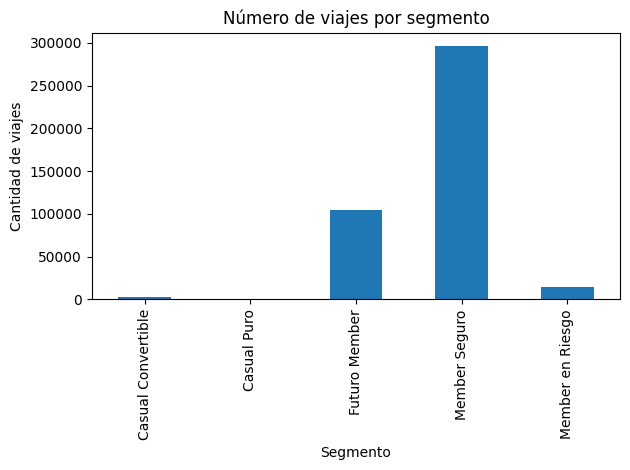

In [70]:
counts = df_clean['segmento'].value_counts().sort_index()

plt.figure()
counts.plot(kind='bar')
plt.title('Número de viajes por segmento')
plt.xlabel('Segmento')
plt.ylabel('Cantidad de viajes')
plt.tight_layout()
plt.show()

Visualizamos la calsificacion generada por el random forest, esa clasificacion se puede mejorar teniendo el id de usuario pero el data set no nos lo proporciona.


In [ ]:

# 1. Calcular porcentajes por segmento
seg_pct = df_clean['segmento'] \
    .value_counts(normalize=True) * 100

# 2. Filtrar solo los tres segmentos que te interesan
segmentos_objetivo = ['Member Seguro', 'Futuro Member', 'Member en Riesgo']
seg_pct = seg_pct.reindex(segmentos_objetivo)

# 3. Graficar
plt.figure()
seg_pct.plot(kind='bar')
plt.title('Porcentaje de viajes por segmento')
plt.xlabel('Segmento')
plt.ylabel('Porcentaje (%)')
plt.ylim(0, seg_pct.max() + 5)  # un poquito de espacio arriba
for i, v in enumerate(seg_pct):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()